<a href="https://colab.research.google.com/github/EvgenyEsin/A-B_test/blob/main/A_B_test_DZ_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ДЗ к семинару 8

На сайте запущен А/В тест с целью увеличить доход. В приложенном excel файле вы найдете сырые данные по результатам эксперимента – user_id, тип выборки variant_name и доход принесенный пользователем revenue.
Проанализируйте результаты эксперимента и напишите свои рекомендации менеджеру.

In [1]:
# Загрузка библиотек
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

import scipy.stats as stats
from scipy import stats
from scipy.stats import shapiro

import statsmodels as sm
from statsmodels.stats.power import TTestIndPower

In [2]:
# Чтение файла
df = pd.read_excel('AB_Test_Results (2).xlsx')
df

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0


In [3]:
# Другой способ чтения файли прямо из источника
from google_drive_downloader import GoogleDriveDownloader as gdd

gdd.download_file_from_google_drive(file_id='1IGMgJP_XqQwA6h_w1KYG7TQJhS15h4c4',
                                    dest_path='./test.xlsx');
# и появился файл test.xlsx, прочитаем его и посмотрим
df = pd.read_excel('AB_Test_Results (2).xlsx')
df

/usr/local/lib/python3.10/dist-packages/openpyxl/worksheet/_reader.py:329: UserWarning: Unknown extension is not supported and will be removed
  warn(msg)


,USER_ID,VARIANT_NAME,REVENUE
0,737,variant,0.0
1,2423,control,0.0
2,9411,control,0.0
3,7311,control,0.0
4,6174,variant,0.0
...,...,...,...
9995,1981,control,0.0
9996,502,variant,0.0
9997,9214,variant,0.0
9998,7741,control,0.0


## Анализ и предобработка данных

Выведем статистику

In [4]:
df.shape

(10000, 3)

In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   USER_ID       10000 non-null  int64  
 1   VARIANT_NAME  10000 non-null  object 
 2   REVENUE       10000 non-null  float64
dtypes: float64(1), int64(1), object(1)
memory usage: 234.5+ KB


In [6]:
df.describe()

,USER_ID,REVENUE
count,10000.000000,10000.000000
mean,4981.080200,0.099447
std,2890.590115,2.318529
min,2.000000,0.000000
25%,2468.750000,0.000000
50%,4962.000000,0.000000
75%,7511.500000,0.000000
max,10000.000000,196.010000


In [7]:
# Проверка на пустые строки
df.isna().sum()

USER_ID         0
VARIANT_NAME    0
REVENUE         0
dtype: int64

Датасет состоит из 10000 строк и 3 столбцов: USER_ID, VARIANT_NAME и REVENUE.

Значения в столбцах различаются по типу переменных: int64, object и float64.

Отрицательных значений нет.

Рассмортим отдельно каждый столбец.

## USER_ID

In [8]:
# провепим на дубликаты
unic = len(df['USER_ID'].unique())
print(f'Уникальных значений: {unic}')

Уникальных значений: 6324


In [9]:
# второй способ
doubble = df['USER_ID'].duplicated().sum()
print(f'Дубликатов: {doubble}')

Дубликатов: 3676


Это значит, что примерно 1/3 пользователей пользовались сайтом более 1 раза. Мы могли бы оставить это как есть, но тогда один и тот же пользователь попал бы и в тестовую, и в контрольную группы, соответственно нам не было бы понятно, повлиял ли на них наш эксперимент.

В итоге, решение примем в конце блока анализа датасета.

## VARIANT_NAME

variant    5016
control    4984
Name: VARIANT_NAME, dtype: int64

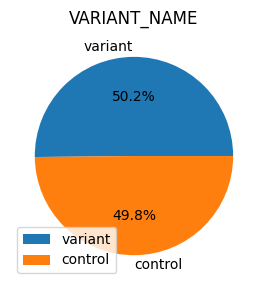

In [10]:
# Обратимся к следующему столбцу с символьными значениями. Выведем в виде таблицы и круговой диаграммы все значения и их количество
df.VARIANT_NAME.value_counts().plot(kind='pie', autopct='%1.1f%%', figsize=(3,3))
plt.legend()
plt.title('VARIANT_NAME')
plt.tight_layout()
plt.axis('off');
df.VARIANT_NAME.value_counts()

Как видим, в этом столбце всего два варианта значений, количество которых равны между собой.

Можно сделать вывод о том, что эти значения говорят о принадлежности юзеров к контрольной или тестовой группе.


Выведем статистику отдельно по двум группам пользователей

In [11]:
df[df['VARIANT_NAME']=='variant'].describe() # тестовая группа

,USER_ID,REVENUE
count,5016.000000,5016.000000
mean,4972.776914,0.070070
std,2876.320625,1.314802
min,3.000000,0.000000
25%,2476.500000,0.000000
50%,4958.500000,0.000000
75%,7415.250000,0.000000
max,10000.000000,58.630000


In [12]:
df[df['VARIANT_NAME']=='control'].describe() # контрольная группа

,USER_ID,REVENUE
count,4984.000000,4984.000000
mean,4989.436798,0.129013
std,2905.145109,3.007524
min,2.000000,0.000000
25%,2466.000000,0.000000
50%,4964.500000,0.000000
75%,7576.250000,0.000000
max,10000.000000,196.010000


По предварительному анализу делаем вывод о том, что на тесте показатели хуже: тут меньше среднее значение покупки и максимальное значение тоже меньше.

## REVENUE

In [13]:
# здесь указан доход, принесенный пользователем
df.REVENUE.describe()

count    10000.000000
mean         0.099447
std          2.318529
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max        196.010000
Name: REVENUE, dtype: float64

Уже можно заметить, что все перцентили равны 0, а среднее арифметическое близко к 0. Следовательно большинство значений этого столбца близки к 0. Однако, смущает значение max = 196. Эти призники говорят о возможных выбросах больших значений.

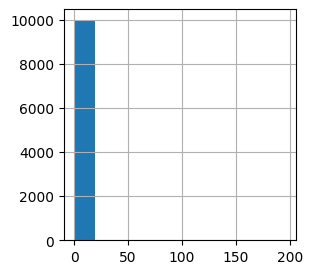

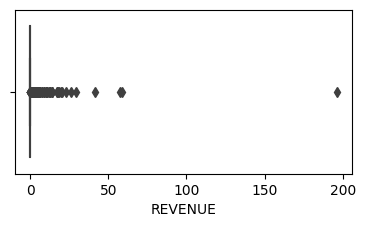

In [14]:
# посмотрим на график распрадалания значений этого столбца.
df['REVENUE'].hist(figsize=(3, 3));
plt.figure(figsize = (20,20))
for i,col in enumerate(['REVENUE']):
    plt.subplot(8,4,i+1)
    sns.boxplot(x = col, data = df)
plt.show()

Действительно, все значения расположены в пределах от 0 до 60. И мы видим единичный выброс 196.

In [15]:
# Удалим выброс
df = df.loc[df['REVENUE']<196]
df.shape

(9999, 3)

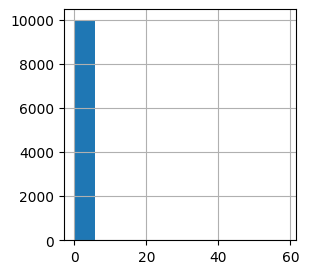

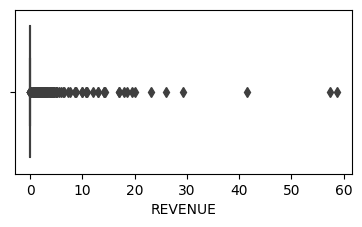

In [16]:
# посмотрим на график распрадалания значений этого столбца без выброса.
df['REVENUE'].hist(figsize=(3, 3));
plt.figure(figsize = (20,20))
for i,col in enumerate(['REVENUE']):
    plt.subplot(8,4,i+1)
    sns.boxplot(x = col, data = df)
plt.show()

Завершая анализ датасета принимаем решение об удалении дубликатов USER_ID:

In [24]:
df = df.drop_duplicates(subset=['USER_ID'])
df.describe()

,USER_ID,REVENUE
count,6323.000000,6323.000000
mean,4984.370868,0.068599
std,2893.861155,1.043898
min,2.000000,0.000000
25%,2467.500000,0.000000
50%,4967.000000,0.000000
75%,7509.000000,0.000000
max,10000.000000,57.460000


In [25]:
# посмотрим на то, как теперь распралены пользователи по группам
df.VARIANT_NAME.value_counts()

variant    3192
control    3131
Name: VARIANT_NAME, dtype: int64

Мы видим, что пользователи распределены примерно поровну и это хорошо. Продолджаем.

Теперь разделим весь датасет на две группы, состоящие из контралной и тестовой части. И нам нужен только столбец REVENUE, чтобы получились списки из размеров покупок.

In [26]:
df_variant = df['REVENUE'][df['VARIANT_NAME']=='variant'] # тестовая половина
df_control = df['REVENUE'][df['VARIANT_NAME']!='variant'] # контрольная половина

### Вывод по анализу датасета.
В датасете содержатся сведения о пользователях сайта и результатах А-В теста. В процессе предобработки данных датасет был проверен на дубликаты и пропуски. Значения уровня дохода заполнены коректно, обнаружен выброс, который был удален. Также из датасета были удалены строки, в которых дублируются одни и теже пользователи. Из датасета было создано 2 списка данных, состоящих из дохода в контрольной и тестовой группе для дальнейшего анализа.

# Применение статистических критериев

Дальше будем работать с созданными списками df_variant и df_control.

Прежде всего необходимо определить тип распределения.

Воспльзуемся тестом на нормальность с помощью функции shapiro

In [28]:
alpha = .05 # зададим уровень значимости в 5%
# H0: распределение нормальное
df_shapiro = shapiro(df.REVENUE) # обращаемся ко всей выборке "покупки" из нашего датасета
print(f'P-Value = {df_shapiro[1]}')
print('Распределение {}нормальное\n'.format( {True: 'не ',
False: ''}[df_shapiro[1] < alpha]));

P-Value = 0.0
Распределение не нормальное



То же самое можно увидеть на графике - данные распределены не нормально.

<Axes: xlabel='REVENUE', ylabel='Count'>

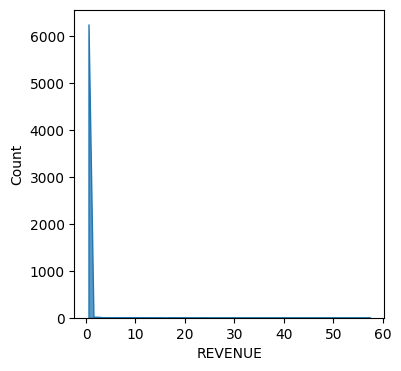

In [29]:
fig, ax = plt.subplots(figsize=(4,4))
sns.histplot(df.REVENUE,stat='count',binwidth=1,multiple="dodge",element ="poly")

Так как распределение не нормальное, то для определения наличия статистической взаимосвязи между двумя независимыми выборками будем использовать непараметрический критерий Манна-Уитни с помощью функции mannwhitneyu из библиотеки scipy.stats:

In [30]:
# H0: Статистическая значимость между вдумя выборками не существует
mw = stats.mannwhitneyu(x=df_control, y = df_variant)
print(f'P-Value = {mw[1]}')
print('Статистическая значимость между вдумя выборками {}установлена\n'.format( {True: 'не ',
False: ''}[mw[1] > alpha]));

P-Value = 0.6799963635531762
Статистическая значимость между вдумя выборками не установлена



# Выводы. Рекомендации.

Так как в результате проведенного эксперимента между двумя группами  отсутствует статистически значимая разница, я бы не рекомендовал применять на практике тестируемое изменение и провести тест повторно, перепроверив корректность его выполнения.